In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text
import matplotlib.lines as mlines

In [2]:
df_foil = pd.read_csv(r'D:\Data Analyst stuffs\Python stuffs\Learn Python for Data Analysis\PYTHON_EXERCISES_UDEMY\Uber Case Study\Datasets\Uber-Jan-Feb-FOIL.csv')

df_foil['date'] = pd.to_datetime(df_foil['date'])

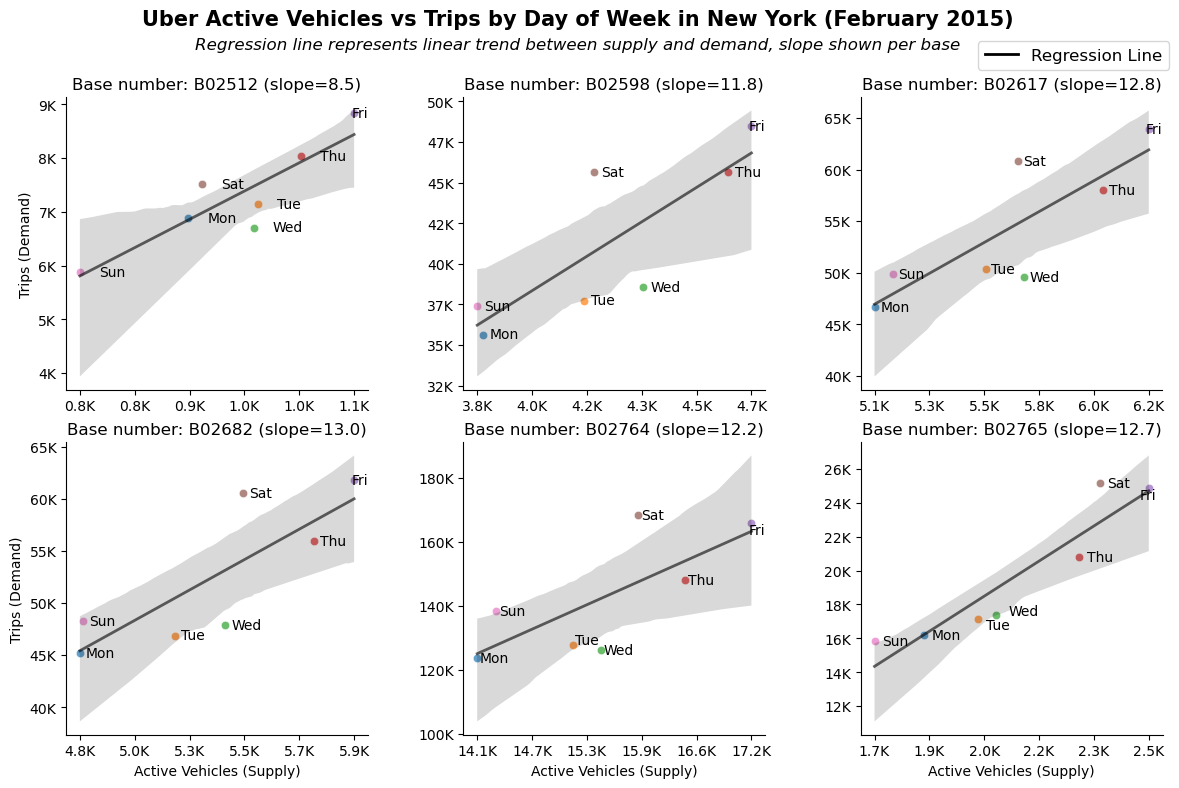

In [ ]:
# FINAL

month_no = 2

df_foil['day_of_week_no'] = df_foil['date'].dt.day_of_week
df_foil['month'] = df_foil['date'].dt.strftime('%B')

df_foil_month = df_foil[df_foil['date'].dt.month == month_no].copy()

df_grouped = (df_foil_month
    .groupby(['dispatching_base_number', 'day_of_week_no'], as_index=False)[['active_vehicles', 'trips']]
    .sum()
)

df_grouped['ratio'] = df_grouped['trips'] / df_grouped['active_vehicles']

days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df_grouped['day_of_week'] = df_grouped['day_of_week_no'].map(lambda x: days[x])
df_grouped.drop(columns='day_of_week_no', inplace=True)

# Create FacetGrid scatterplots for each dispatching base
g1 = sns.FacetGrid(
    data=df_grouped,
    col='dispatching_base_number',
    hue='day_of_week',
    col_wrap=3,
    sharex=False, sharey=False,
    height=4
)

# Plot scatter points: active_vehicles vs trips
g1.map(sns.scatterplot, 'active_vehicles', 'trips', alpha=0.7)

# Loop through each facet and add regression line + labels
for ax, base in zip(g1.axes.flat, df_grouped['dispatching_base_number'].unique()):
    df_base = df_grouped[df_grouped['dispatching_base_number'] == base]

    # Compute linear regression slope and intercept
    slope, intercept = np.polyfit(df_base['active_vehicles'], df_base['trips'], 1)

    # Plot regression line
    sns.regplot(
        data=df_base,
        x='active_vehicles',
        y='trips',
        scatter=False,
        ax=ax,
        line_kws={'color':'black', 'alpha':0.6, 'lw':2}
    )
    
    # Add title with slope information
    ax.set_title(f'Base number: {base} (slope={slope:.1f})')

    # Format axis tick labels (in thousands)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{(y/1000):.1f}K'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y/1000)}K'))

    # Get min and max of x-axis values
    x_min, x_max = df_base['active_vehicles'].min(), df_base['active_vehicles'].max()

    # Ensure consistent number of ticks across facets
    ax.set_xticks(np.linspace(x_min, x_max, 6))

    # Add day-of-week text labels and adjust to avoid overlap
    texts = [ax.text(x+20, y, day, va='center') 
             for x, y, day in zip(df_base['active_vehicles'], df_base['trips'], df_base['day_of_week'])]
    adjust_text(texts, ax=ax)

# Set axis labels for all facets
g1.set_axis_labels('Active Vehicles (Supply)', 'Trips (Demand)')

# Add overall title and subtitle
g1.figure.subplots_adjust(top=0.87)
month_name = df_foil_month['month'].iloc[0]
plt.suptitle(
    f'Uber Active Vehicles vs Trips by Day of Week in New York ({month_name} 2015)',
    fontsize=15,
    weight='bold'
)

# Configure subtitle text and position
g1.figure.text(
    0.5,
    0.93,
    'Regression line represents linear trend between supply and demand, slope shown per base',
    ha='center',
    fontsize=12,
    style='italic'
)

# Add legend for regression line
reg_line = mlines.Line2D([], [], color='black', lw=2, label='Regression Line')
g1.figure.legend(
    handles=[reg_line],
    loc='upper right',
    bbox_to_anchor=(1, 0.95),
    fontsize=12,
    frameon=True
)

plt.show()